/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:234: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['a', 'b', 'c', 'd'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['e', 'f', 'g', 'h'])


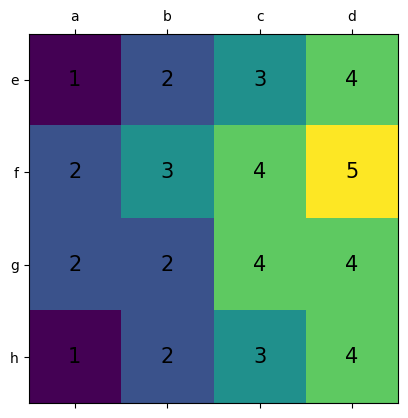

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:252: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['insert', 'fairness', 'notions', 'here'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:253: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No Missing', 'MCAR', 'MAR', 'NMAR'])


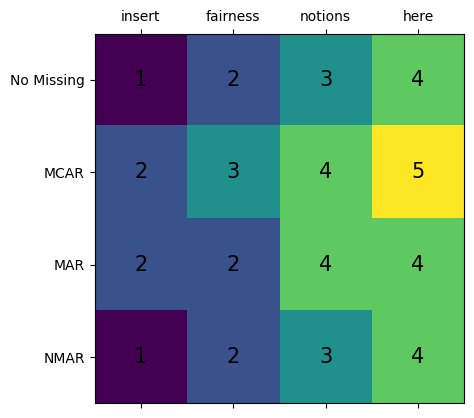

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


In [1]:
import pandas as pd
import os
import sys
from src.cleaning import datacleaning
from src import data_generation
import pandas as pd
import numpy as np
import aif360
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from sklearn.model_selection import train_test_split
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import average_odds_difference
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
data = datacleaning.cleaning(os.path.join(os.path.dirname(
    os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [3]:
target = sys.argv[1]

if target == "test":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/test.csv'))

if target == "all":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [4]:
data.isna().sum()

complaint_id                   0
complainant_ethnicity       5505
complainant_gender          4195
complainant_age_incident    4829
allegation                     1
contact_reason               199
substantiated                  0
dtype: int64

In [5]:
data.head()

,complaint_id,complainant_ethnicity,complainant_gender,complainant_age_incident,allegation,contact_reason,substantiated
0,42835,Black,Female,38.0,Failure to provide RTKA card,Report-domestic dispute,True
1,24601,Black,Male,26.0,Action,Moving violation,True
2,24601,Black,Male,26.0,Race,Moving violation,True
3,26146,Black,Male,45.0,Question,PD suspected C/V of violation/crime - street,True
4,40253,NaN,NaN,16.0,Physical force,Report-dispute,True


## Missingness Creation

We want the attribute with missingness to have around the same proportion of missingness for each type. This is because we don't want the amount of missingness to be a confounding factor in our results.

In [6]:
mcar = data.copy()
mcar = data_generation.mcar(mcar, 'substantiated')

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [7]:
mcar['substantiated'].isna().sum() / mcar.shape[0]

0.20300977276815158

In [8]:
mcar = mcar.dropna(subset = 'substantiated')

In [9]:
mar = data.copy()
mar = data_generation.mar(mar, 'substantiated', 'complainant_ethnicity', 0.3)

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[miss_column].iloc[i] = np.nan


In [10]:
mar['substantiated'].isna().sum() / mar.shape[0]

0.19647460878949577

In [11]:
mar = mar.dropna(subset = 'substantiated')

In [12]:
nmar = data.copy()
nmar = data_generation.nmar(nmar, 'substantiated', 0.3)

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [13]:
nmar['substantiated'].isna().sum() / nmar.shape[0]

0.18865039870495834

In [14]:
nmar = nmar.dropna(subset = 'substantiated')

Now we will "handle" the missingness by dropping missing values.

## Applying Fairness Notions


In [15]:
nypd = data.dropna()

In [16]:
cat = ["complainant_ethnicity", "complainant_gender", "complainant_age_incident", "allegation", "contact_reason"]

In [17]:
#model for finding fairness notions when no NaN values are not present in the data
def model(train, test, cats):
    ohe = OneHotEncoder(handle_unknown='ignore')
    
    traincat_df = train[cats]
    # OHE train categorical
    train_ohe = ohe.fit_transform(traincat_df)
    # concat non-cat train features
    train_len = train.shape[0]

    train_num_feats = np.concatenate(
        [np.reshape(train.complainant_age_incident.values, (train_len, 1))
        ], axis = 1
    )
    
    # concatenate train OHE features with non-cat features
    train_feats = pd.DataFrame(np.concatenate([train_ohe.todense(), train_num_feats], axis = 1))
    train_feats['complainant_ethnicity'] = (train['complainant_ethnicity'] == "White").tolist()
    train_feats['complainant_gender'] = (train['complainant_gender'] == "Male").tolist()
    y_train = train.substantiated.values.astype('int')
    
    mod = LogisticRegression(C = 1.0, class_weight='balanced')
    mod.fit(train_feats, y_train)
    
    testcat_df = test[cats]
    # OHE train categorical
    test_ohe = ohe.transform(testcat_df)
    # concat non-cat train features
    test_len = test.shape[0]

    test_num_feats = np.concatenate(
        [np.reshape(test.complainant_age_incident.values, (test_len, 1)),
        ], axis = 1
    )
        
    # concatenate test OHE features with non-cat features
    test_feats = pd.DataFrame(np.concatenate([test_ohe.todense(), test_num_feats], axis = 1))
    test_feats['complainant_ethnicity'] = (test['complainant_ethnicity'] == "White").tolist()
    test_feats['complainant_gender'] = (test['complainant_gender'] == "Male").tolist()
    y_test = test.substantiated.values.astype('int')
    
    pred = mod.predict(test_feats)
    
    parity = statistical_parity_difference(pd.Series(y_test), pd.Series(pred))
    odds = average_odds_difference(pd.Series(y_test), pd.Series(pred))
    opportunity = equal_opportunity_difference(pd.Series(y_test), pd.Series(pred))
    
    
    print("statistical parity: " + str(parity))
    print("Equality of odds: " + str(odds))
    print("Equality of opportunity: " + str(opportunity))
    
    
    return [parity,odds,opportunity]

In [18]:
#model for finding fairness notions when no NaN values are present in the data
def model_missing(train, test, cats):
    ohe = OneHotEncoder(handle_unknown='ignore')
    
    traincat_df = train[cats]
    # OHE train categorical
    train_ohe = ohe.fit_transform(traincat_df)
    # concat non-cat train features
    train_len = train.shape[0]

    train_num_feats = np.concatenate(
        [np.reshape(train.complainant_age_incident.values, (train_len, 1))
        ], axis = 1
    )
    
    # concatenate train OHE features with non-cat features
    train_feats = pd.DataFrame(np.concatenate([train_ohe.todense(), train_num_feats], axis = 1))
    train_feats['complainant_ethnicity'] = (train['complainant_ethnicity'] == "White").tolist()
    train_feats['complainant_gender'] = (train['complainant_gender'] == "Male").tolist()
    y_train = train.substantiated.values.astype('int')
    
    mod = HistGradientBoostingClassifier()
    mod.fit(train_feats, y_train)
    
    testcat_df = test[cats]
    # OHE train categorical
    test_ohe = ohe.transform(testcat_df)
    # concat non-cat train features
    test_len = test.shape[0]

    test_num_feats = np.concatenate(
        [np.reshape(test.complainant_age_incident.values, (test_len, 1)),
        ], axis = 1
    )
        
    # concatenate test OHE features with non-cat features
    test_feats = pd.DataFrame(np.concatenate([test_ohe.todense(), test_num_feats], axis = 1))
    test_feats['complainant_ethnicity'] = (test['complainant_ethnicity'] == "White").tolist()
    test_feats['complainant_gender'] = (test['complainant_gender'] == "Male").tolist()
    y_test = test.substantiated.values.astype('int')
    
    pred = mod.predict(test_feats)
    
    parity = statistical_parity_difference(pd.Series(y_test), pd.Series(pred))
    odds = average_odds_difference(pd.Series(y_test), pd.Series(pred))
    opportunity = equal_opportunity_difference(pd.Series(y_test), pd.Series(pred))
    
    
    print("statistical parity: " + str(parity))
    print("Equality of odds: " + str(odds))
    print("Equality of opportunity: " + str(opportunity))
    
    
    return [parity,odds,opportunity]

### Calculating fairnes notions for No Missingness At All

In [19]:
train, test = train_test_split(nypd, test_size=0.2)

In [20]:
#storing fairness notions for no missingness
no_missing_fairness = []
no_missing = model(train, test, cat)
no_missing_fairness.append(no_missing)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


statistical parity: -0.5915158164198209
Equality of odds: -0.5178534642961596
Equality of opportunity: -0.3744360902255639


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Specificity is ill-defin

### Fairness notions for NMAR

In [21]:
train_nmar, test_nmar = train_test_split(nmar, test_size=0.2)

In [22]:
nmar_fairness = []
nmar_model = model_missing(train_nmar, test_nmar, cat)
nmar_fairness.append(nmar_model)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


statistical parity: 0.0508130081300813
Equality of odds: 0.07504303200306006
Equality of opportunity: 0.12390029325513197


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for MCAR

In [23]:
train_mcar, test_mcar = train_test_split(mcar, test_size=0.2)


In [24]:
mcar_fairness = []
mcar_model = model_missing(train_mcar, test_mcar, cat)
mcar_fairness.append(mcar_model)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


statistical parity: 0.03253714500658266
Equality of odds: -0.4499275114787773
Equality of opportunity: 0.08466819221967964


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for MAR

In [25]:
train_mar, test_mar = train_test_split(mar, test_size=0.2)


In [26]:
mar_fairness = []
mar_model = model_missing(train_mar, test_mar, cat)
mar_fairness.append(mar_model)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


statistical parity: -0.9442164179104477
Equality of odds: -0.919188670087315
Equality of opportunity: -0.8692077727952168


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#put our fairness statistics into arrays for future usage
par= [no_missing_fairness[0][0],nmar_fairness[0][0],mcar_fairness[0][0],mar_fairness[0][0]]
odds= [no_missing_fairness[0][1],nmar_fairness[0][1],mcar_fairness[0][1],mar_fairness[0][1]]
opp = [no_missing_fairness[0][2],nmar_fairness[0][2],mcar_fairness[0][2],mar_fairness[0][2]]

## Visualizing Our Results

In [28]:
import matplotlib.pyplot as plt

In [29]:
labels = ['No Missingess,', 'NMAR', 'MCAR', 'MAR']

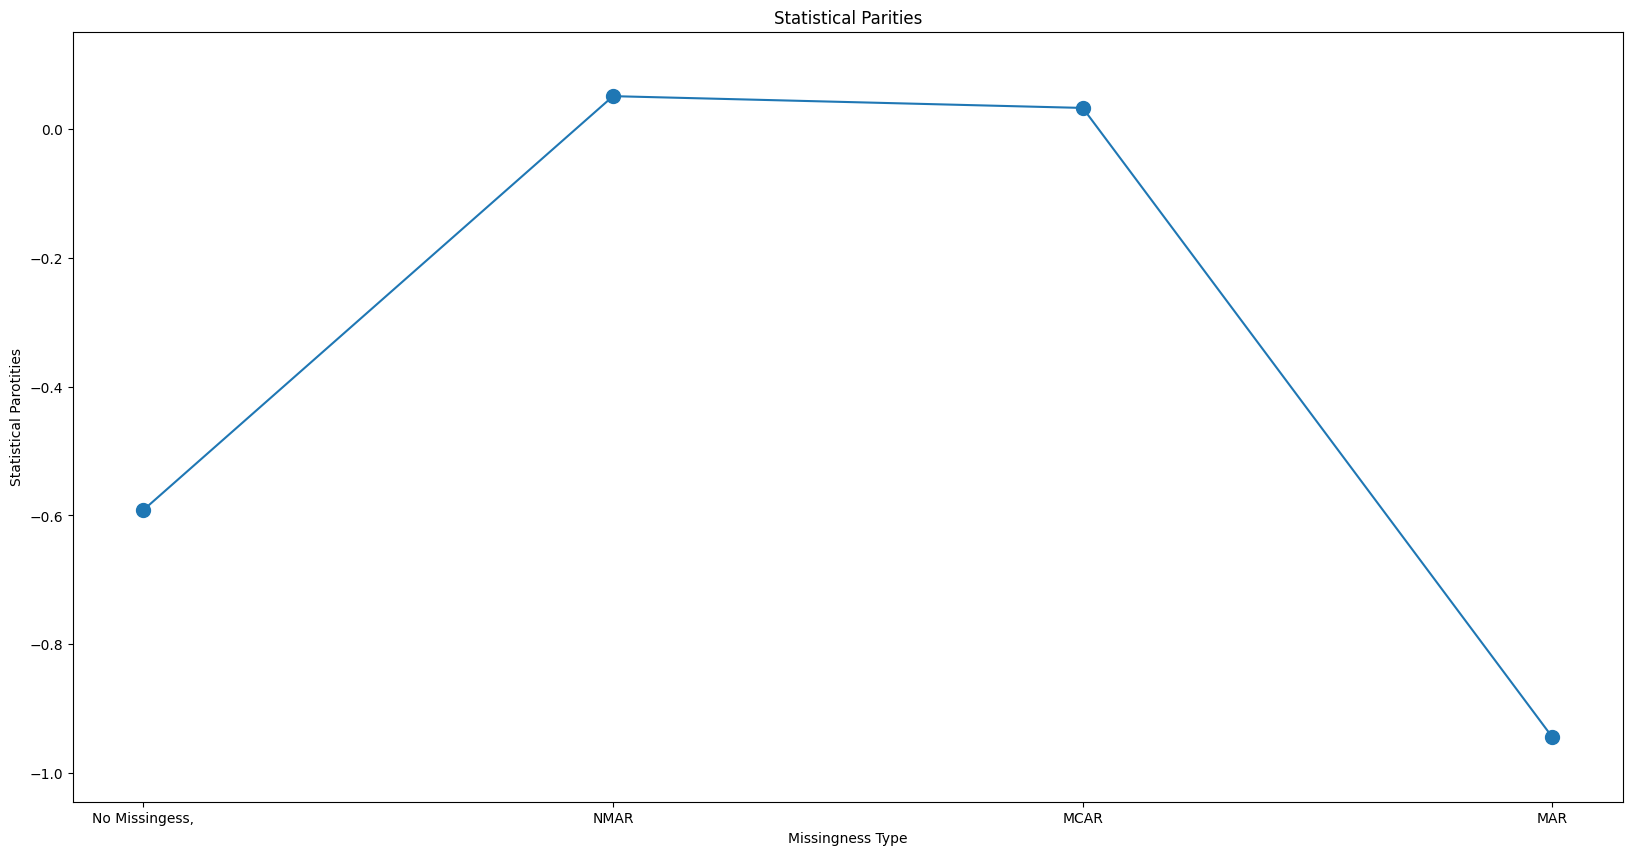

In [30]:
plt.figure(figsize = (20, 10))
plt.title('Statistical Parities')
plt.xlabel('Missingness Type')
plt.ylabel('Statistical Parotities')
plt.ylim(min(par) - 0.1, max(par) + 0.1)
plt.plot(labels, par, marker='.', markersize = 20)

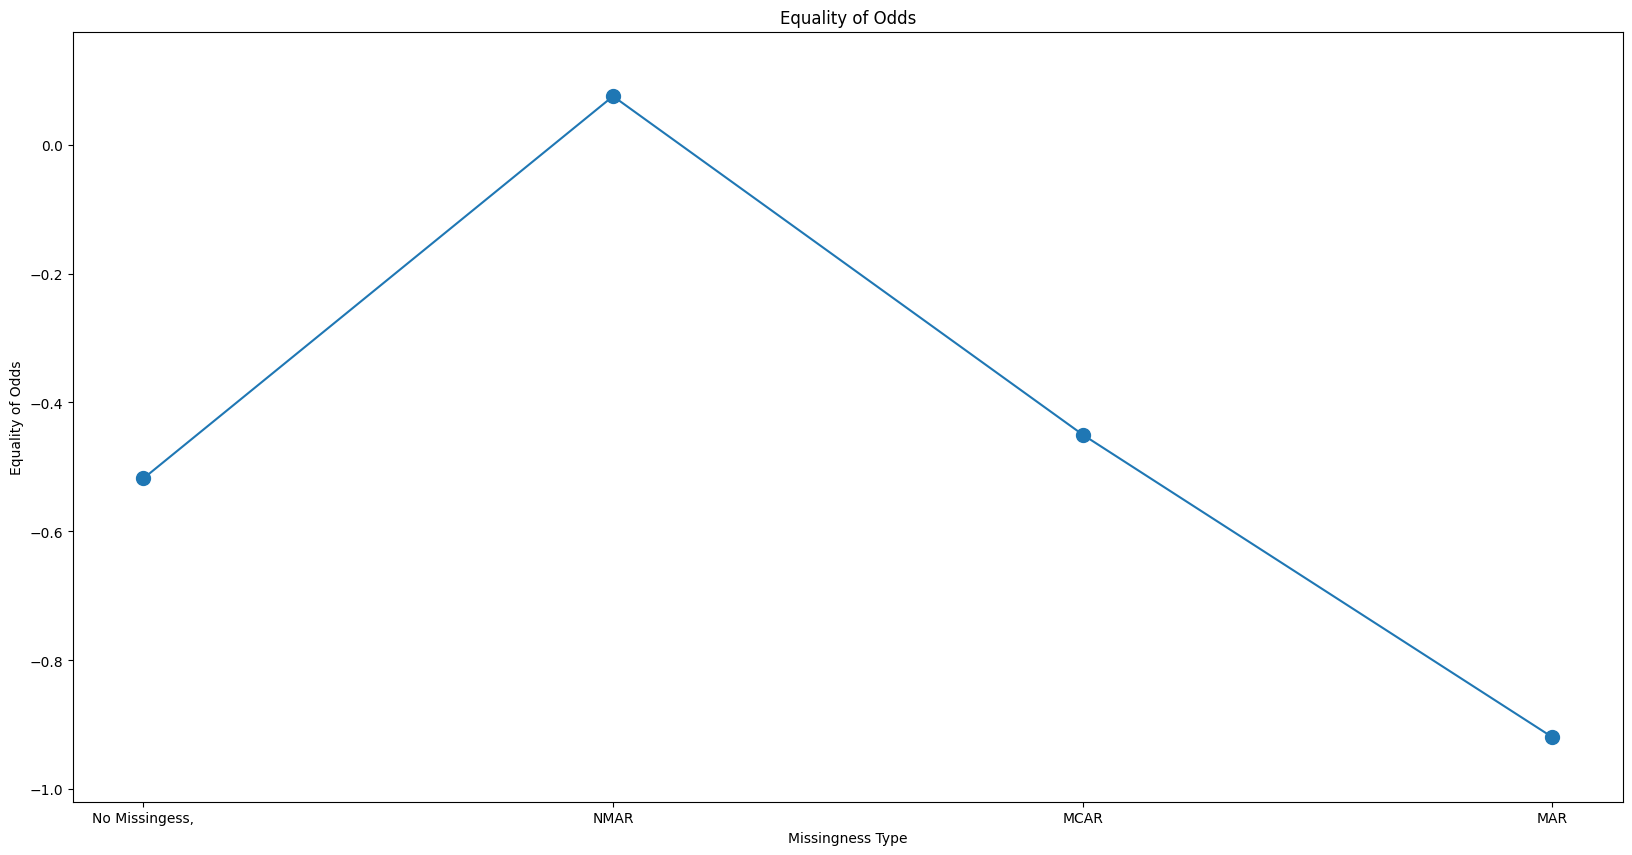

In [31]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Odds')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Odds')
plt.ylim(min(odds)-0.1,max(odds) + 0.1)
plt.plot(labels, odds, marker='.', markersize = 20)

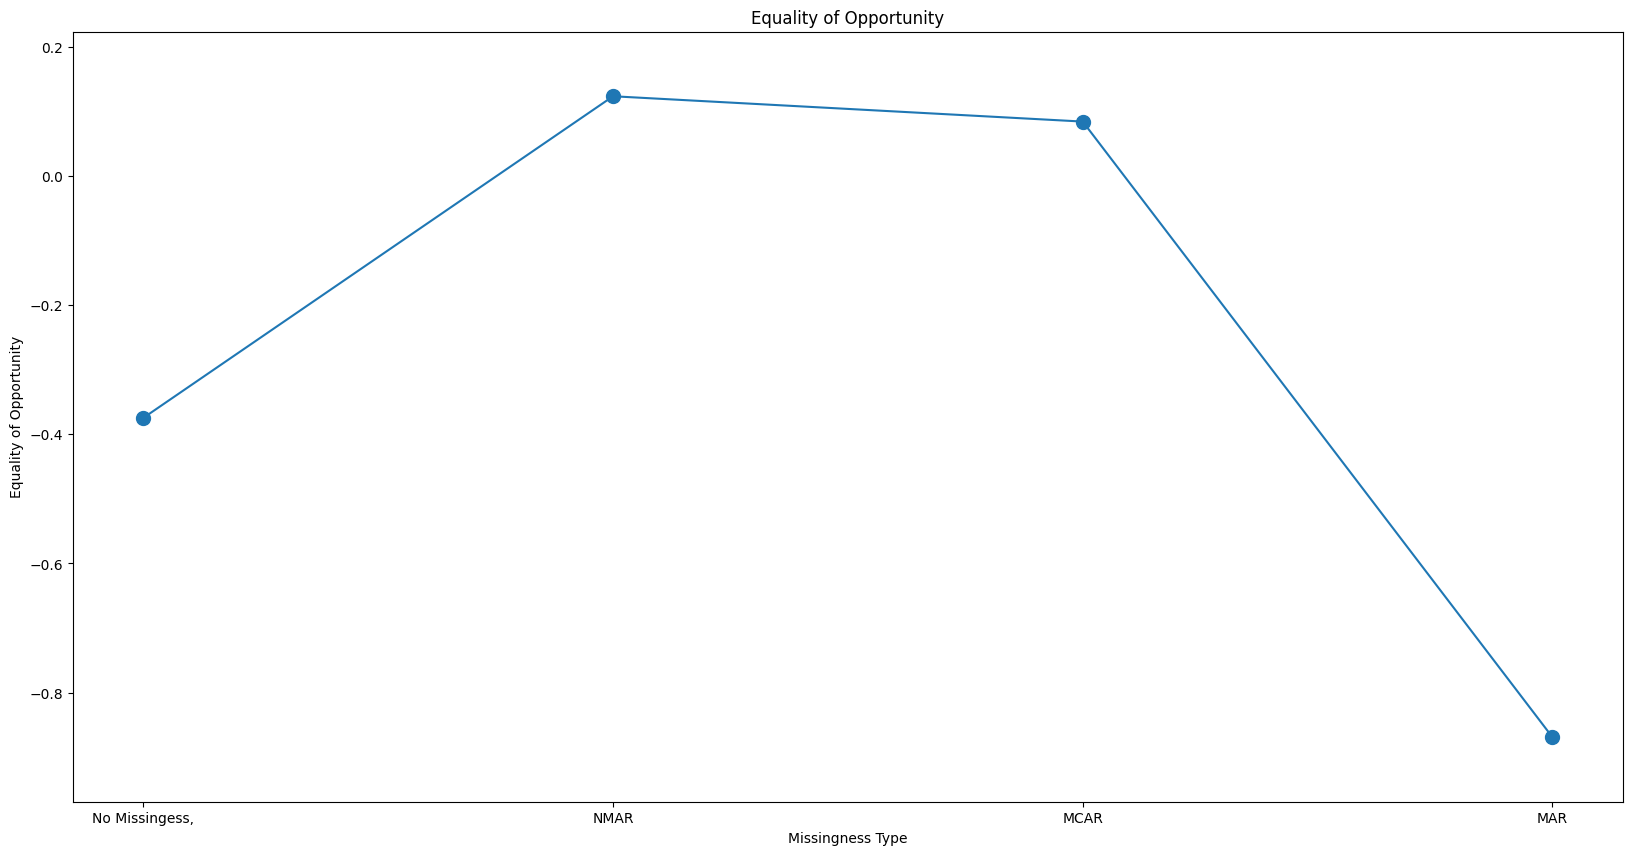

In [32]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Opportunity')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Opportunity')
plt.ylim(min(opp)-0.1,max(opp) + 0.1)
plt.plot(labels, opp, marker='.', markersize = 20)